In [1]:
# Recommendation: `conda install --channel conda-forge geopandas`
import numpy as np
import math
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import entropy 
import shapely
import json
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from tqdm import tqdm

In [2]:
def splits_to_regions_binary(row, splits):
    if splits is None:
        return 0
    if len(splits) == 0:
        return 0

    num = 0
    for v in splits:
        num = 2 * num + row[v]
    return num

def count_disjoints(geometry):
    if type(geometry) == Polygon:
        return 1 
    else:
        return len(geometry.geoms)

In [3]:
with open("../states.json", "r") as f:
    states = json.load(f)
state = "PA"
DEGREE_LIMIT = 0
voting_precincts = gpd.read_file(states[state]["FILE"])
voting_precincts = voting_precincts.to_crs("EPSG:4269")
# voting_precincts = voting_precincts.dissolve(by="COUNTYFP", aggfunc="sum")
n_districts = states[state]["NUM_OF_DISTRICTS"]
pop = states[state]["POPULATION"]
d_votes = states[state]["DEMOCRAT_VOTES"]
r_votes = states[state]["REPUBLICAN_VOTES"]
print(voting_precincts.columns)
voting_precincts.sample(n=1)

Index(['GEOID20', 'G18GOVRWAG', 'G18USSDCAS', 'NAME', 'G18USSLKER', 'VTDST',
       'STATEFP', 'G18USSGGAL', 'COUNTYFP', 'G18USSRBAR', 'G18GOVDWOL',
       'G18GOVGGLO', 'G18GOVLKRA', 'VTDST20', 'G16TRERVOI', 'NAMELSAD20',
       'AWATER20', 'LSAD20', 'G16AUDGSWE', 'NAME20', 'G16AUDRBRO',
       'G16PRERTRU', 'G16TRELBAB', 'COUNTYFP20', 'G16TREGCOM', 'G16PREDCLI',
       'STATEFP20', 'G16USSRTOO', 'G16PRECCAS', 'G16USSLCLI', 'G16AUDDDEP',
       'G16USSDMCG', 'FUNCSTAT20', 'INTPTLAT20', 'G16TREDTOR', 'G16ATGRRAF',
       'G16ATGDSHA', 'G16PREGSTE', 'ALAND20', 'G16PRELJOH', 'G16AUDLMIN',
       'INTPTLON20', 'VTDI20', 'MTFCC20', 'TOTPOP19', 'TOTPOP10', 'HPOP19',
       'HCVAP19', 'HPOP10', 'NHPICVAP19', 'NHCVAP19', 'NHPOP19', 'NHPIPOP19',
       'NHPOP10', '2MOREPOP19', '2MORECVAP1', '2MOREPOP10', 'ASIANPOP19',
       'ASIANCVAP1', 'ASIANPOP10', 'AMINPOP19', 'AMINCVAP19', 'AMINPOP10',
       'BCVAP19', 'BPOP19', 'BPOP10', 'NHPIPOP10', 'WPOP19', 'WCVAP19',
       'WPOP10', 'CVAP19', 'geo

,GEOID20,G18GOVRWAG,G18USSDCAS,NAME,G18USSLKER,VTDST,STATEFP,G18USSGGAL,COUNTYFP,G18USSRBAR,...,AMINPOP10,BCVAP19,BPOP19,BPOP10,NHPIPOP10,WPOP19,WCVAP19,WPOP10,CVAP19,geometry
940,4200300B900,111.0,197.0,PITTSBURGH WARD 20 DISTRICT 18,4.0,00B900,42,2.0,003,113.0,...,0.0,1.428571,1.5,2.0,0.0,488.057808,425.302419,575.0,440.106743,"POLYGON ((-80.05120 40.40194, -80.05084 40.402..."


In [4]:
# voting_precincts = voting_precincts.to_crs("EPSG:4269")
# voting_precincts['GEOID20'] = voting_precincts['GEOID20'].astype(str)

print([x for x in voting_precincts.columns if "POP" in x.upper()])
print([x for x in voting_precincts.columns if "D" in x.upper()])
print(voting_precincts.shape)
# voting_precincts.sample(n=5)

['TOTPOP19', 'TOTPOP10', 'HPOP19', 'HPOP10', 'NHPOP19', 'NHPIPOP19', 'NHPOP10', '2MOREPOP19', '2MOREPOP10', 'ASIANPOP19', 'ASIANPOP10', 'AMINPOP19', 'AMINPOP10', 'BPOP19', 'BPOP10', 'NHPIPOP10', 'WPOP19', 'WPOP10']
['GEOID20', 'G18USSDCAS', 'VTDST', 'G18GOVDWOL', 'VTDST20', 'NAMELSAD20', 'LSAD20', 'G16AUDGSWE', 'G16AUDRBRO', 'G16PREDCLI', 'G16AUDDDEP', 'G16USSDMCG', 'G16TREDTOR', 'G16ATGDSHA', 'ALAND20', 'G16AUDLMIN', 'VTDI20']
(9178, 72)


In [5]:
voting_precincts['REPRESENTATIVE_POINT'] =  voting_precincts.centroid # voting_precincts.representative_point() https://gis.stackexchange.com/a/414263
voting_precincts['RP_LON'] = voting_precincts['REPRESENTATIVE_POINT'].apply(lambda p: p.x)
voting_precincts['RP_LAT'] = voting_precincts['REPRESENTATIVE_POINT'].apply(lambda p: p.y)

print(voting_precincts.shape)
# voting_precincts.sample(n=5)

C:\Users\yagne\AppData\Local\Temp\ipykernel_30108\1766291162.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  voting_precincts['REPRESENTATIVE_POINT'] =  voting_precincts.centroid # voting_precincts.representative_point() https://gis.stackexchange.com/a/414263


(9178, 75)


In [6]:
orig_voting = voting_precincts[[d_votes, r_votes]].sum()/(voting_precincts[[d_votes, r_votes]].sum().sum())
orig_voting

G18GOVDWOL    0.586676
G18GOVRWAG    0.413324
dtype: float64

In [8]:
def entropy_score_parta_fn(df_1, df_2, dem_col, rep_col, **kwargs):
    # Always takes in both dataframes

    # Calculate values
    summed_pops_1 = df_1[[dem_col, rep_col]].sum()
    dem_prop_1 = summed_pops_1[dem_col]/(summed_pops_1[rep_col]+summed_pops_1[dem_col])
    rep_prop_1 = summed_pops_1[rep_col]/(summed_pops_1[rep_col]+summed_pops_1[dem_col])
    score = entropy([dem_prop_1, rep_prop_1], base=2)

    # Will always minimize, for entropy negate
    return -score

def entropy_score_mean_fn(df_1, df_2, dem_col, rep_col, **kwargs):
    # Always takes in both dataframes

    # Calculate values
    summed_pops_1 = df_1[[dem_col, rep_col]].sum()
    dem_prop_1 = summed_pops_1[dem_col]/(summed_pops_1[rep_col]+summed_pops_1[dem_col])
    rep_prop_1 = summed_pops_1[rep_col]/(summed_pops_1[rep_col]+summed_pops_1[dem_col])
    score_1 = entropy([dem_prop_1, rep_prop_1], base=2)

    summed_pops_2 = df_2[[dem_col, rep_col]].sum()
    dem_prop_2 = summed_pops_2[dem_col]/(summed_pops_2[rep_col]+summed_pops_2[dem_col])
    rep_prop_2 = summed_pops_2[rep_col]/(summed_pops_2[rep_col]+summed_pops_2[dem_col])
    score_2 = entropy([dem_prop_2, rep_prop_2], base=2)

    score = (score_1+score_2)/2 # Average of both
    # Will always minimize, for entropy negate
    return -score
    

def abs_diff_parta_fn(df_1, df_2, dem_col, rep_col, **kwargs):
    # Always takes in both dataframes

    # Calculate values
    summed_pops_1 = df_1[[dem_col, rep_col]].sum()
    dem_prop_1 = summed_pops_1[dem_col]/(summed_pops_1[rep_col]+summed_pops_1[dem_col])
    rep_prop_1 = summed_pops_1[rep_col]/(summed_pops_1[rep_col]+summed_pops_1[dem_col])
    score = abs(dem_prop_1-rep_prop_1) 
    return score
    
def abs_diff_mean_fn(df_1, df_2, dem_col, rep_col, **kwargs):
    # Always takes in both dataframes

    # Calculate values
    summed_pops_1 = df_1[[dem_col, rep_col]].sum()
    dem_prop_1 = summed_pops_1[dem_col]/(summed_pops_1[rep_col]+summed_pops_1[dem_col])
    rep_prop_1 = summed_pops_1[rep_col]/(summed_pops_1[rep_col]+summed_pops_1[dem_col])
    score_1 = abs(dem_prop_1-rep_prop_1) 

    summed_pops_2 = df_2[[dem_col, rep_col]].sum()
    dem_prop_2 = summed_pops_2[dem_col]/(summed_pops_2[rep_col]+summed_pops_2[dem_col])
    rep_prop_2 = summed_pops_2[rep_col]/(summed_pops_2[rep_col]+summed_pops_2[dem_col])
    score_2 = abs(dem_prop_2-rep_prop_2)

    score = (score_1+score_2)/2 # Average of both
    return score

def match_statewide_mean_fn(df_1, df_2, dem_col, rep_col, **kwargs):
    orig_dem = kwargs["orig_dem"]
    orig_rep = kwargs["orig_rep"]
    # Always takes in both dataframes
    # Calculate values
    summed_pops_1 = df_1[[dem_col, rep_col]].sum()
    dem_prop_1 = summed_pops_1[dem_col]/(summed_pops_1[rep_col]+summed_pops_1[dem_col])
    rep_prop_1 = summed_pops_1[rep_col]/(summed_pops_1[rep_col]+summed_pops_1[dem_col])
    score_1 = abs(dem_prop_1-orig_dem)+abs(rep_prop_1-orig_rep)

    summed_pops_2 = df_2[[dem_col, rep_col]].sum()
    dem_prop_2 = summed_pops_2[dem_col]/(summed_pops_2[rep_col]+summed_pops_2[dem_col])
    rep_prop_2 = summed_pops_2[rep_col]/(summed_pops_2[rep_col]+summed_pops_2[dem_col])
    score_2 = abs(dem_prop_2-orig_dem)+abs(rep_prop_2-orig_rep)

    score = (score_1+score_2)/2 # Average of both
    return score




In [26]:
# %%time
def split_this(df, n_districts, n_split=1, pop_col = "POPULATION", dem_col = "G18GOVD", rep_col = "G18GOVR", score_fn=abs_diff_parta_fn, n_sample_angles=None, degree_limit = 0, dissolve_check = False):
    # print(n_districts)
    if n_districts != 1:
        # Get district ratios:
        if n_districts % 2 == 0:
            part_a = n_districts/2
            part_b = n_districts/2
        else:
            part_a = math.ceil(n_districts/2)
            part_b = math.floor(n_districts/2)

        # Get Total Population
        pop_total = df[pop_col].sum()

        # Get Population Center
        pop_center_LON = (df['RP_LON'] * df[pop_col]).sum()/pop_total
        pop_center_LAT =  (df['RP_LAT'] * df[pop_col]).sum()/pop_total

        # Re-center LAT/LON relative to the Population Center
        df['RECENTERED_LON'] = df['RP_LON'] - pop_center_LON
        df['RECENTERED_LAT'] = df['RP_LAT'] - pop_center_LAT

        # Get Angle by using ARCTAN(RECENTERED_LAT, RECENTERED_LON)
        # df['RECENTERED_RATIO'] = df['RECENTERED_LAT']/df['RECENTERED_LON']
        df['RECENTERED_ANGLE'] = np.degrees(np.arctan2(df['RECENTERED_LAT'], df['RECENTERED_LON']))
        df['RECENTERED_ANGLE'] = df['RECENTERED_ANGLE'].apply(lambda x: x if x > 0 else x + 360)


        ## LOOP for d in 0 to 359 ##
        start_angles = np.linspace(0,359,360)
        if n_sample_angles:
            start_angles = np.random.choice(start_angles, size=n_sample_angles)
        # Set Tracker for Angle Ranges and Competitiveness
        angle_ranges = []

        for d in tqdm(start_angles):
            # Reset Angle to be Relative to d
            df['RESETTED_ANGLE'] = df['RECENTERED_ANGLE'] - d
            df['RESETTED_ANGLE'] = df['RESETTED_ANGLE'].apply(lambda x: x if x > 0 else (x+360))
            df = df.sort_values('RESETTED_ANGLE').reset_index(drop=True)

            # Spin Clock Around till you achieve the desired ratio
            i = 0
            captured_pop = 0
            while captured_pop < (part_a)/(part_a+part_b)*pop_total:
                captured_pop += df.loc[i, pop_col]
                i += 1
            final_angle = df.loc[i-1, 'RECENTERED_ANGLE']

            ## Check if angle range loops past 360 for conditions:
            a1, a2 = d, final_angle

            # If specified, skip past any second hand angle that is not far away from the first handle angle.
            if abs(a2 - a1) <= degree_limit:
                continue

            if a1 < a2:
                    df[f'SPLIT_{n_split}'] = df['RECENTERED_ANGLE'].apply(lambda x: 1 if a1 <= x <= a2 else 0)
            elif a1 > a2:
                    df[f'SPLIT_{n_split}'] = df['RECENTERED_ANGLE'].apply(lambda x: 1 if ((x >= a1) or (x <= a2)) else 0)

            # Dissolve Check for Non-Contiguity
            if dissolve_check:
                dissolved_df = df.dissolve(by=f'SPLIT_{n_split}')
                dissolved_df['disjoints'] = dissolved_df['geometry'].apply(lambda x: count_disjoints(x))
                dissolved_pieces = dissolved_df['disjoints'].sum()
            else:
                dissolved_pieces = 0

            df_a = df.loc[df[f'SPLIT_{n_split}'] == 1].copy().reset_index(drop=True)
            df_b = df.loc[df[f'SPLIT_{n_split}'] == 0].copy().reset_index(drop=True)


            # Metric Calculation, Change to any function chosen.
            score = score_fn(df_a, df_b, dem_col, rep_col, orig_dem=orig_voting[dem_col], orig_rep=orig_voting[rep_col])
            angle_ranges.append({"start":d, "end":final_angle, "score":score, "disjoints": dissolved_pieces})


        ars = pd.DataFrame(angle_ranges)
        # ars['entropy_prod'] = (ars['entropy_a']*ars["entropy_b"])/(ars['entropy_a']+ars["entropy_b"])
        # ars = ars.sort_values("entropy_prod", ascending=False).reset_index(drop=True)
        ars = ars.sort_values(["disjoints","score"], ascending=True).reset_index(drop=True)

        a1, a2 = ars.iloc[0]["start"], ars.iloc[0]["end"]
        ## Check if angle range loops past 360 for conditions:
        if a1 < a2:
            df[f'SPLIT_{n_split}'] = df['RECENTERED_ANGLE'].apply(lambda x: 1 if a1 <= x <= a2 else 0)
        elif a1 > a2:
            df[f'SPLIT_{n_split}'] = df['RECENTERED_ANGLE'].apply(lambda x: 1 if ((x >= a1) or (x <= a2)) else 0)

        df_a = df.loc[df[f'SPLIT_{n_split}'] == 1].copy().reset_index(drop=True)
        df_b = df.loc[df[f'SPLIT_{n_split}'] == 0].copy().reset_index(drop=True)

        split_this(df_a, part_a, n_split=n_split+1, pop_col = pop_col, dem_col = dem_col, rep_col = rep_col, n_sample_angles=n_sample_angles, degree_limit=degree_limit)
        split_this(df_b, part_b, n_split=n_split+1, pop_col = pop_col, dem_col = dem_col, rep_col = rep_col, n_sample_angles=n_sample_angles, degree_limit=degree_limit)

        
    else:
        holder.append(df)

holder = []   
split_this(df=voting_precincts, n_districts=n_districts, pop_col=pop, dem_col=d_votes, rep_col=r_votes, degree_limit=DEGREE_LIMIT, score_fn=abs_diff_parta_fn)

 42%|████▎     | 153/360 [00:02<00:02, 72.53it/s]

In [ ]:
all_districts = pd.concat(holder).reset_index(drop=True)
split_columns = [c for c in all_districts.columns if c.startswith("SPLIT_")]

for c in split_columns:
    all_districts[c] = all_districts[c].fillna(0)

all_districts['DISTRICT'] = all_districts.apply(splits_to_regions_binary, splits=split_columns, axis=1)

In [ ]:
all_districts['DISTRICT'].nunique()

18

In [ ]:
# Shuffle for coloring
n_districts = all_districts['DISTRICT'].nunique()
random_districts = np.random.choice(np.linspace(0,n_districts-1,n_districts), size=n_districts, replace=False, p=None)
shuffle_dict = dict(zip(all_districts["DISTRICT"].unique(), random_districts))
all_districts["SHUFFLED"] = all_districts["DISTRICT"].apply(lambda x: shuffle_dict[x])

In [ ]:
print(all_districts.groupby("SHUFFLED").sum()[pop].sum())
all_districts.groupby("SHUFFLED").sum()[pop]

12791530.0


SHUFFLED
0.0     707657.174144
1.0     709896.478526
2.0     711170.671245
3.0     710835.352438
4.0     709982.467886
5.0     712488.454079
6.0     709866.019588
7.0     711497.573432
8.0     709240.789450
9.0     710518.599523
10.0    709184.118105
11.0    710222.827114
12.0    714243.432084
13.0    710968.551845
14.0    707648.619394
15.0    713359.562526
16.0    711921.168570
17.0    710828.140054
Name: TOTPOP19, dtype: float64

In [ ]:
all_districts.columns

Index(['GEOID20', 'G18GOVRWAG', 'G18USSDCAS', 'NAME', 'G18USSLKER', 'VTDST',
       'STATEFP', 'G18USSGGAL', 'COUNTYFP', 'G18USSRBAR', 'G18GOVDWOL',
       'G18GOVGGLO', 'G18GOVLKRA', 'VTDST20', 'G16TRERVOI', 'NAMELSAD20',
       'AWATER20', 'LSAD20', 'G16AUDGSWE', 'NAME20', 'G16AUDRBRO',
       'G16PRERTRU', 'G16TRELBAB', 'COUNTYFP20', 'G16TREGCOM', 'G16PREDCLI',
       'STATEFP20', 'G16USSRTOO', 'G16PRECCAS', 'G16USSLCLI', 'G16AUDDDEP',
       'G16USSDMCG', 'FUNCSTAT20', 'INTPTLAT20', 'G16TREDTOR', 'G16ATGRRAF',
       'G16ATGDSHA', 'G16PREGSTE', 'ALAND20', 'G16PRELJOH', 'G16AUDLMIN',
       'INTPTLON20', 'VTDI20', 'MTFCC20', 'TOTPOP19', 'TOTPOP10', 'HPOP19',
       'HCVAP19', 'HPOP10', 'NHPICVAP19', 'NHCVAP19', 'NHPOP19', 'NHPIPOP19',
       'NHPOP10', '2MOREPOP19', '2MORECVAP1', '2MOREPOP10', 'ASIANPOP19',
       'ASIANCVAP1', 'ASIANPOP10', 'AMINPOP19', 'AMINCVAP19', 'AMINPOP10',
       'BCVAP19', 'BPOP19', 'BPOP10', 'NHPIPOP10', 'WPOP19', 'WCVAP19',
       'WPOP10', 'CVAP19', 'geo

In [ ]:
# all_districts[['geometry', pop, r_votes, d_votes, 'DISTRICT', 'SHUFFLED'] + split_columns].to_file(f"{state}_degreelimit_{DEGREE_LIMIT}.shp")

<AxesSubplot:>

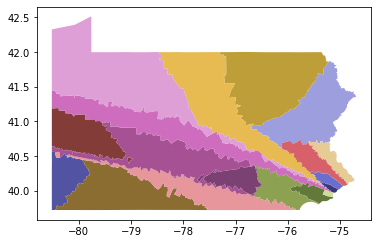

In [ ]:
districts_df = all_districts.dissolve(by="SHUFFLED")
districts_df.plot(cmap="tab20b")

## Step by Step Review

In [ ]:
def split_review(input_df, split, split_cols, plot_party=False, figsize = (8,6), save=None):
    input_df['TEMP_DISTRICT'] = input_df.apply(splits_to_regions_binary, splits=split_cols[:split], axis=1)
    n_districts = input_df['TEMP_DISTRICT'].nunique()
    # random_districts = np.random.choice(np.linspace(0,n_districts-1,n_districts), size=n_districts, replace=False, p=None)
    random_districts = np.linspace(0,n_districts-1,n_districts)
    shuffle_dict = dict(zip(input_df["TEMP_DISTRICT"].unique(), random_districts))
    input_df["TEMP_DISTRICT"] = input_df["TEMP_DISTRICT"].apply(lambda x: shuffle_dict[x])

    districts_df = input_df.dissolve(by = "TEMP_DISTRICT", aggfunc={"TEMP_DISTRICT": "first", d_votes: "sum", r_votes: "sum"})
    districts_df["Dem_Ratio"] = districts_df[d_votes]/(districts_df[d_votes] + districts_df[r_votes])
    districts_df["Rep_Ratio"] = districts_df[r_votes]/(districts_df[d_votes] + districts_df[r_votes])

    
    fig, ax = plt.subplots(1,1, figsize=figsize)

    if plot_party:
        base = districts_df.plot(ax=ax, cmap="RdBu", column="Dem_Ratio", legend=True, vmin=0, vmax=1, edgecolor='black')
        dem_wins = districts_df.loc[districts_df["Dem_Ratio"] >= districts_df["Rep_Ratio"]].shape[0]
        rep_wins = districts_df.loc[districts_df["Dem_Ratio"] < districts_df["Rep_Ratio"]].shape[0]
        title = f"Districts: {districts_df.shape[0]} | D-R: {dem_wins}-{rep_wins}"
    else:
        base = districts_df.plot(ax=ax, cmap="tab20b", edgecolor='black')
        title = f"Districts - {districts_df.shape[0]}"
    

    points = []
    for x in range(2**split):
        sub = input_df.loc[input_df['TEMP_DISTRICT'] == x]
        if sub.shape[0] == 0:
            continue
        pop_center_LON = (sub['RP_LON'] * sub[pop]).sum()/sub[pop].sum()
        pop_center_LAT =  (sub['RP_LAT'] * sub[pop]).sum()/sub[pop].sum()
        point = shapely.geometry.Point(pop_center_LON, pop_center_LAT)
        points.append(point)
    pop_center_df = gpd.GeoDataFrame(geometry=points)
    pop_center_df.plot(ax=ax, color="white", linewidth=1.0, edgecolor="black")
    plt.title(title)
    if save:
        fig.savefig(save)
    plt.show()

    return districts_df


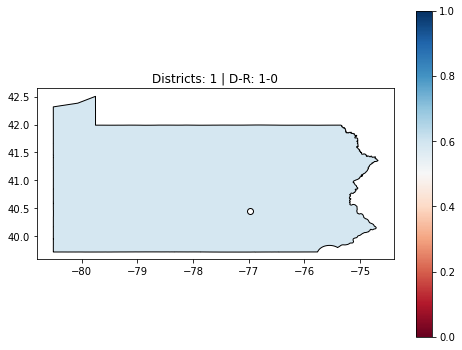

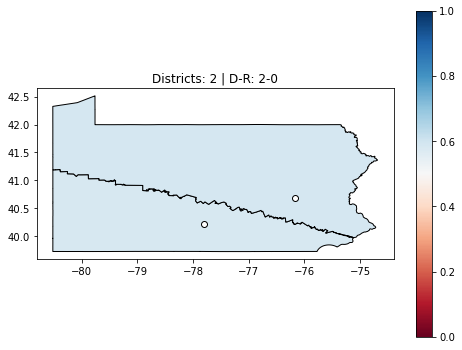

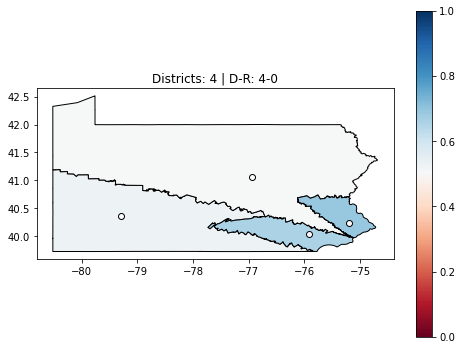

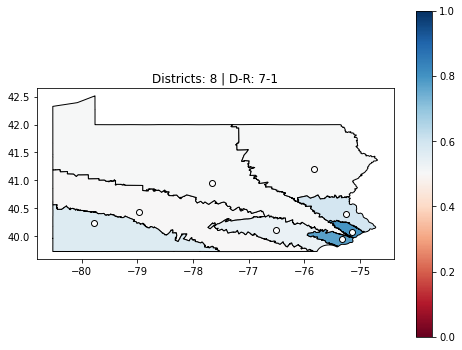

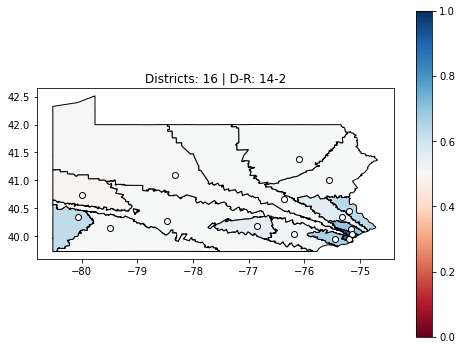

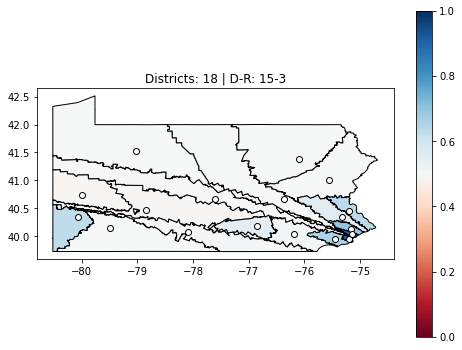

In [ ]:
for s in range(len(split_columns)+1):
    _ = split_review(input_df=all_districts, split=s, split_cols=split_columns, plot_party=True)

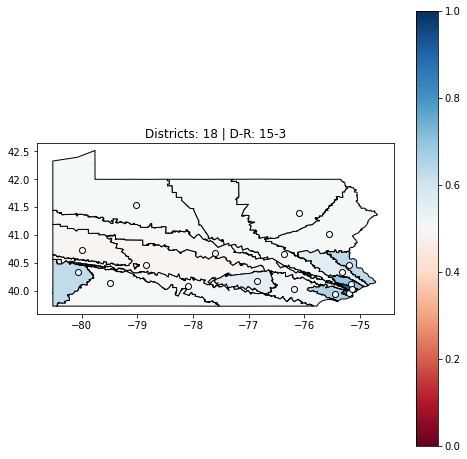

In [ ]:
_ = split_review(input_df=all_districts, split=5, split_cols=split_columns, plot_party=True, figsize=(8,8))

In [22]:
_.sort_values("Rep_Ratio")

,geometry,TEMP_DISTRICT,G18GOVDWOL,G18GOVRWAG,Dem_Ratio,Rep_Ratio
TEMP_DISTRICT,,,,,,
17.0,"POLYGON ((-75.12215 39.97036, -75.12212 39.970...",17.0,217308.000000,21632.000000,0.909467,0.090533
8.0,"POLYGON ((-75.17225 39.91239, -75.17227 39.912...",8.0,261799.862761,30217.689969,0.896521,0.103479
16.0,"POLYGON ((-75.00198 40.02798, -75.00335 40.027...",16.0,195242.225365,85063.850188,0.696532,0.303468
7.0,"POLYGON ((-75.42074 39.82114, -75.42030 39.821...",7.0,209432.317871,109650.140948,0.656358,0.343642
15.0,"POLYGON ((-74.84343 40.09800, -74.84352 40.097...",15.0,176658.436951,102355.643077,0.633152,0.366848
4.0,"POLYGON ((-80.51950 39.74432, -80.51949 39.744...",4.0,186485.760582,111200.172923,0.626451,0.373549
14.0,"MULTIPOLYGON (((-74.85990 40.09669, -74.85962 ...",14.0,169431.000000,135240.000000,0.556111,0.443889
6.0,"POLYGON ((-76.68213 39.93727, -76.68185 39.937...",6.0,152604.579251,123365.211134,0.552976,0.447024
5.0,"POLYGON ((-75.75447 39.75563, -75.75468 39.755...",5.0,139006.105322,132458.383007,0.512060,0.487940
